# Compare CTD data in Puget Sound, cruise vs buoy
8/16,12, 7/18/2024

Emilio Mayorga

**TODO:**
- ~~Add data files to a `data` subfolder~~
- Change plot order: CTD first, then ORCA
- Is the dinosip conda env the old one from last year? If so, create a fresh one with Py3.12, then retest everything, including the website
- Use relative paths for file paths to data files
- Make sure to say this notebook builds on the intro notebook on the ctd package. Add link, https://pyoceans.github.io/python-ctd/quick_intro-output.html
- Add reading and mapping (and plotting?) of all other cruise casts. Upload to the github repo the zip file containing all the cnv files? The files are 8.8 MB zipped and 20.7 MB decompressed
- Add intro text describing the goals of this notebook


In [1]:
from datetime import timedelta
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

## Data from DINO SIP Cruise

We'll use the Python [`ctd` package](https://pyoceans.github.io/python-ctd/) to read the `.cnv` file for one cast, exported by [SeaBird](https://www.seabird.com/) software. This file includes data from all sensors (CTD and other sensors) as well as metadata about the cruise and the cast, such as location (latitude, longitude and station name), time, sensor names and calibration, etc.

### Read and examine the `.cnv` export file

We'll use the file [data/cruises/20240718_CTD05_p28.cnv](data/cruises/20240718_CTD05_p28.cnv)

In [2]:
import ctd

In [3]:
cast = ctd.from_cnv(Path("./data/cruises") / "20240718_CTD05_p28.cnv")

# Separate the data into down cast and up cast
down_cast_df, up_cast_df = cast.split()

`cast` is a custom object created by the `ctd` package that holds the CTD cast data and metadata. The `ctd` package contains custom functionality for data pre-processing and plotting ocean vertical profiles.

**In this notebook we'll focus on the `down_cast_df` data only.** This is a [Pandas](https://pandas.pydata.org) DataFrame. The index and columns in this DataFrame show the variables that are read: pressure, temperature, salinity, conductivity, beam transmission, fluorescence, pH, photosynthetically active radiation, and a data quality flag.

Let's look at the first 5 rows, to get a feel for the data:

In [4]:
down_cast_df.head()

,t090C,sal00,c0S/m,sbox0Mm/Kg,CStarTr0,flECO-AFL,ph,par,flag
Pressure [dbar],,,,,,,,,
6.543,14.0140,30.7695,3.737626,225.061,68.6557,6.8175,8.034,137.86,False
6.558,14.0138,30.7709,3.737760,224.907,68.9782,6.8175,8.029,137.86,False
6.543,14.0135,30.7719,3.737836,224.743,69.0319,6.8175,8.034,138.65,False
6.558,14.0134,30.7718,3.737811,224.720,69.0050,6.8175,8.034,139.04,False
6.543,14.0128,30.7725,3.737842,224.852,68.9782,6.8175,8.029,139.04,False


File metadata is stored in a dictionary for convenient access. Let's look at some of that metadata.

In [5]:
metadata = cast._metadata

metadata.keys()

dict_keys(['name', 'header', 'config', 'names', 'skiprows', 'time', 'lon', 'lat'])

We'll store cast time, latitude and longitude in variables for reuse later in the notebook

In [6]:
dcast_time, dcast_lat, dcast_lon = metadata['time'], metadata['lat'], metadata['lon']
dcast_time, dcast_lat, dcast_lon

(datetime.datetime(2024, 7, 18, 15, 54),
 47.71333333333333,
 -122.41933333333333)

In [7]:
print(metadata['config'])

# nquan = 10
# nvalues = 26928
# units = specified
# name 0 = depSM: Depth [salt water, m]
# name 1 = t090C: Temperature [ITS-90, deg C]
# name 2 = sal00: Salinity, Practical [PSU]
# name 3 = c0S/m: Conductivity [S/m]
# name 4 = sbox0Mm/Kg: Oxygen, SBE 43 [umol/kg]
# name 5 = CStarTr0: Beam Transmission, WET Labs C-Star [%]
# name 6 = flECO-AFL: Fluorescence, WET Labs ECO-AFL/FL [mg/m^3]
# name 7 = ph: pH
# name 8 = par: PAR/Irradiance, Biospherical/Licor
# name 9 = flag:  0.000e+00
# span 0 =      0.619,    180.351
# span 1 =    11.1966,    16.1026
# span 2 =    29.2562,    30.7725
# span 3 =   3.442453,   3.755137
# span 4 =    186.942,    411.365
# span 5 =    61.9648,    93.5652
# span 6 =     0.0776,     8.7223
# span 7 =      7.539,      8.284
# span 8 = 1.0000e-12, 4.0607e+03
# span 9 = 0.0000e+00, 0.0000e+00
# interval = seconds: 0.0416667
# start_time = Jul 18 2024 15:54:00 [NMEA time, header]
# bad_flag = -9.990e-29
# <Sensors count="11" >
#   <sensor Channel="1" >
#     <!--

Use the `ctd` `plot_cast` function to plot depth profiles of raw temperature and conductivity on different axes. Note that the data is a bit "noisy".

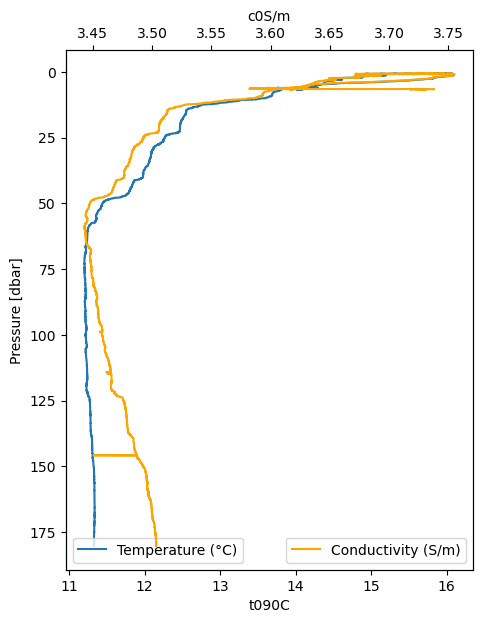

In [8]:
ax0 = down_cast_df["t090C"].plot_cast(label="Temperature (°C)")
ax1 = down_cast_df["c0S/m"].plot_cast(
    ax=ax0,
    label="Conductivity (S/m)",
    color="orange",
    secondary_y=True,
)

ax0.legend(loc="lower left")
ax1.legend(loc="lower right");

Let's see some of the other variables, though we won't look at them again. The level of customization involved in this plot is more than what `plot_cast` can handle, so we'll have to do a lot of manual setup with `matplotlib`.

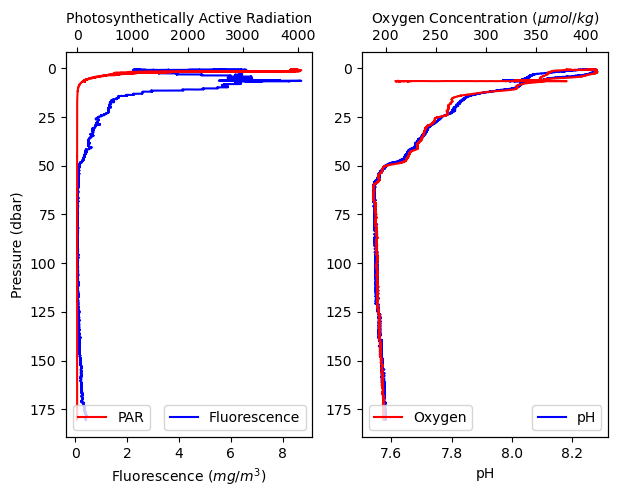

In [9]:
# subplots returns two "axes", one for each sub plot
_, [ax0, ax1] = plt.subplots(ncols=2, nrows=1, figsize=(7, 5))

# Left subplot
ax0.invert_yaxis()
ax0.plot(down_cast_df["flECO-AFL"], down_cast_df.index, color='blue', label="Fluorescence")
ax0.set_xlabel("Fluorescence ($mg/m^3$)")
ax0.set_ylabel("Pressure (dbar)")
ax0_top = ax0.twiny()
ax0_top.plot(down_cast_df["par"], down_cast_df.index, color='red', label="PAR")
ax0_top.set_xlabel("Photosynthetically Active Radiation")
ax0.legend(loc="lower right")
ax0_top.legend(loc="lower left")

# Right subplot
ax1.invert_yaxis()
ax1.plot(down_cast_df["ph"], down_cast_df.index, color='blue', label="pH")
ax1.set_xlabel("pH")
ax1_top = ax1.twiny()
ax1_top.plot(down_cast_df["sbox0Mm/Kg"], down_cast_df.index, color='red', label="Oxygen")
ax1_top.set_xlabel("Oxygen Concentration ($\mu mol / kg$)")
ax1.legend(loc="lower right")
ax1_top.legend(loc="lower left");

### Pre-process temperature and conductivity

Let's use functions provided by the `ctd` package to perform data cleaning and pre-processing steps that are typically applied to such data. Note how the functions are "chained" to apply in a sequence, one after the other. We'll retain only temperature, conductivity and pressure (in the DataFrame index).

In [10]:
down_cast_df = down_cast_df[["t090C", "c0S/m"]]

proc = (
    # Remove all data above the water line
    down_cast_df.remove_above_water()
    # Remove all the data above a certain index value where index can be pressure or depth (it can be unreliable)
    .remove_up_to(idx=7)
    # Remove data spikes
    .despike(n1=2, n2=20, block=100)
    # Apply "low-pass" filter, to remove high-frequency wiggles
    .lp_filter()
    # Remove pressure reversals from the index
    .press_check()
    # Interpolate gaps (this is a Pandas function)
    .interpolate()
    # Bin average the index (usually pressure) to a given interval
    .bindata(delta=1, method="interpolate")
    # Smooth the data using a window with the requested size
    .smooth(window_len=21, window="hanning")
)

proc.head()

,t090C,c0S/m
8.0,13.784330,3.600170
9.0,13.606445,3.587466
10.0,13.431428,3.574971
11.0,13.264619,3.563063
12.0,13.110621,3.552074


Now let's compare the raw vs post-processed temperature:

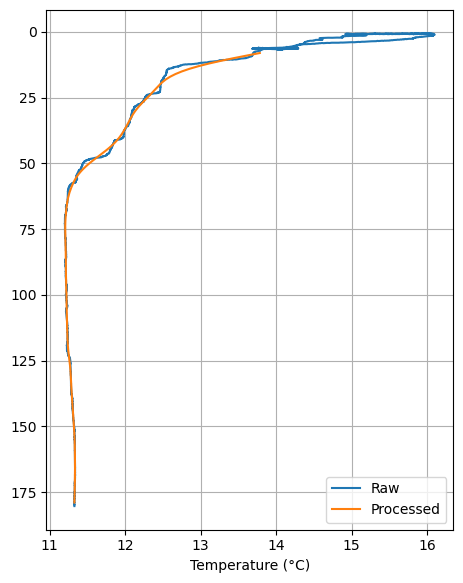

In [11]:
ax = down_cast_df["t090C"].plot_cast(label="Raw")
proc["t090C"].plot_cast(ax=ax, label="Processed")

ax.grid(True)
ax.legend(loc="lower right")
plt.xlabel("Temperature (°C)");

### Calculate some standard derived variables

We can now compute a set of standard oceanographic ("hydrographic") variables using published "thermodynamic equations of seawater", also known as equations of state. These variables are more rigorous versions of the preceding variables. We'll use the "TEOS-10" equations implemented in the [GSW-Python package](https://teos-10.github.io/GSW-Python/index.html) (`gsw`).

In [12]:
import gsw

In [13]:
# Pressure values are found in the Dataframe index
press = proc.index

# SP: Practical Salinity (unitless, but often referred to as PSU)
# SA: Absolute Salinity (g/kg)
# CT: Conservative temperature of seawater from in-situ temperature (degrees Celsius)
# sigma0_CT: Potential density anomaly with respect to a reference pressure of 0 dbar (potential density - 1000 kg/m^3)
# depth: Depth below the water surface (m)

SP = gsw.SP_from_C(proc["c0S/m"].to_numpy() * 10.0, proc["t090C"].to_numpy(), press)
SA = gsw.SA_from_SP(SP, press, dcast_lon, dcast_lat)
CT = gsw.CT_from_t(SA, proc["t090C"].to_numpy(), press)
sigma0_CT = gsw.sigma0(SA, CT)
depth = -gsw.z_from_p(press, dcast_lat)

proc = (
    proc.assign(SP=SP)
    .assign(SA=SA)
    .assign(CT=CT)
    .assign(sigma0_CT=sigma0_CT)
    .assign(depth=depth)
)

In [14]:
proc.head()

,t090C,c0S/m,SP,SA,CT,sigma0_CT,depth
8.0,13.784330,3.600170,29.691206,29.834354,13.895472,22.138643,7.932935
9.0,13.606445,3.587466,29.712093,29.855307,13.715728,22.189819,8.924530
10.0,13.431428,3.574971,29.732651,29.875928,13.538896,22.239883,9.916120
11.0,13.264619,3.563063,29.752240,29.895602,13.370365,22.287345,10.907706
12.0,13.110621,3.552074,29.770323,29.913761,13.214778,22.330927,11.899286


Finally, let's compare the derived "conservative temperature" with the "pre-processed" and raw temperature variables:

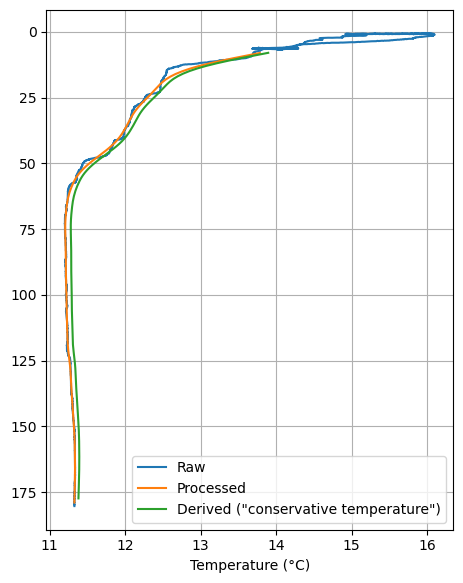

In [15]:
ax = down_cast_df["t090C"].plot_cast(label="Raw")
proc["t090C"].plot_cast(ax=ax, label="Processed")
proc.plot(ax=ax, y='depth', x='CT', kind='line', label='Derived ("conservative temperature")')

ax.grid(True)
ax.legend(loc="lower right")
plt.xlabel("Temperature (°C)");

## Data from the ORCA Point Wells depth-profiling buoy (mooring)

Buoy (mooring) water temperature data was downloaded manually from NVS, specifically from https://nvs.nanoos.org/Explorer?action=oiw:fixed_platform:APL_NPB1PtWells:observations:H1_WaterTemp. Buoy latitude and longitude were copied and pasted from the "Details" tab on that NVS pop-up window.

We'll use the file [data/ORCAmooring/APL_NPB1PtWells-H1_WaterTemp.csv](data/ORCAmooring/APL_NPB1PtWells-H1_WaterTemp.csv)

In [16]:
buoy_lon, buoy_lat = -122.3972, 47.7612

In [17]:
buoy_temp_df = pd.read_csv(
    Path("./data/ORCAmooring") / "APL_NPB1PtWells-H1_WaterTemp.csv", 
    parse_dates=["Date and Time"],
    # The temperature column uses blank character as the no-data value
    na_values=[' ']
)

buoy_temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4408 entries, 0 to 4407
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype                    
---  ------             --------------  -----                    
 0   Date and Time      4408 non-null   datetime64[ns, UTC-07:00]
 1    Depth (M)         4408 non-null   object                   
 2    Water Temp. (°C)  4260 non-null   float64                  
dtypes: datetime64[ns, UTC-07:00](1), float64(1), object(1)
memory usage: 103.4+ KB


Remove rows with missing (`NA`, "not available") temperature, then rename columns to simpler, easier-to-use strings

In [18]:
buoy_temp_df.dropna(subset=' Water Temp. (°C)', inplace=True)

buoy_temp_df.rename(
    columns={'Date and Time': 'date_time',
             ' Depth (M)': 'depth',
             ' Water Temp. (°C)': 'temp'},
    inplace=True
)

In [19]:
buoy_temp_df.tail()

,date_time,depth,temp
4403,2024-07-18 12:00:18-07:00,-79 m,11.332
4404,2024-07-18 12:00:18-07:00,-7 m,14.715
4405,2024-07-18 12:00:18-07:00,-80 m,11.329
4406,2024-07-18 12:00:18-07:00,-8 m,13.893
4407,2024-07-18 12:00:18-07:00,-9 m,13.054


Convert depth column to a numeric, positive-down_cast_df float type. Depth values are strings that look like this: " -79 m", with one blank space before the number and the letter m (meters) after the number, but with a blank space separating them. We'll convert to positive-down_cast_df values for consistency with the CTD data and to follow the usual convention for depth.

In [20]:
buoy_temp_df['depth'] = (
    buoy_temp_df['depth']
    .str.split(' ').str[1]
    .astype(float)
    * (-1)
)

Sort on `date_time` and `depth`, to ensure the data are in a form that's directly usable in the plots.

In [21]:
buoy_temp_df.sort_values(
    by=['date_time', 'depth'],
    ascending=[True, True],
    inplace=True
)

In [22]:
buoy_temp_df.tail()

,date_time,depth,temp
4400,2024-07-18 12:00:18-07:00,76.0,11.336
4401,2024-07-18 12:00:18-07:00,77.0,11.337
4402,2024-07-18 12:00:18-07:00,78.0,11.335
4403,2024-07-18 12:00:18-07:00,79.0,11.332
4405,2024-07-18 12:00:18-07:00,80.0,11.329


In [23]:
buoy_temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4260 entries, 50 to 4405
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype                    
---  ------     --------------  -----                    
 0   date_time  4260 non-null   datetime64[ns, UTC-07:00]
 1   depth      4260 non-null   float64                  
 2   temp       4260 non-null   float64                  
dtypes: datetime64[ns, UTC-07:00](1), float64(2)
memory usage: 133.1 KB


List unique date time values and save them in `buoy_datetimes` for reuse.

In [24]:
buoy_datetimes = buoy_temp_df['date_time'].unique()
buoy_datetimes

<DatetimeArray>
['2024-06-21 10:15:14-07:00', '2024-06-21 12:00:13-07:00',
 '2024-06-22 00:00:14-07:00', '2024-06-22 12:00:14-07:00',
 '2024-06-23 00:00:14-07:00', '2024-06-23 12:00:14-07:00',
 '2024-06-24 00:00:14-07:00', '2024-06-24 12:00:14-07:00',
 '2024-06-25 00:00:14-07:00', '2024-06-25 12:00:14-07:00',
 '2024-06-26 00:00:15-07:00', '2024-06-26 12:00:14-07:00',
 '2024-06-27 00:00:14-07:00', '2024-06-27 12:00:14-07:00',
 '2024-06-28 00:00:15-07:00', '2024-06-28 12:00:15-07:00',
 '2024-06-29 00:00:15-07:00', '2024-06-29 12:00:15-07:00',
 '2024-06-30 00:00:15-07:00', '2024-06-30 12:00:15-07:00',
 '2024-07-01 00:00:14-07:00', '2024-07-01 12:00:15-07:00',
 '2024-07-02 00:00:15-07:00', '2024-07-02 12:00:16-07:00',
 '2024-07-03 00:00:16-07:00', '2024-07-03 12:00:15-07:00',
 '2024-07-04 00:00:15-07:00', '2024-07-04 12:00:16-07:00',
 '2024-07-05 00:00:15-07:00', '2024-07-05 12:00:16-07:00',
 '2024-07-06 00:00:15-07:00', '2024-07-06 12:00:16-07:00',
 '2024-07-07 00:00:16-07:00', '2024-07-0

Let's make a quick plot. Note that here we use the Pandas DataFrame `plot` function, which is based on `matplotlib`. We'll plot the last available profile, accessible as `buoy_datetimes[-1]`.

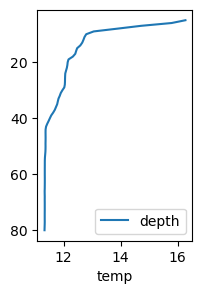

In [25]:
(
    buoy_temp_df[buoy_temp_df.date_time == buoy_datetimes[-1]]
    .plot(y='depth', x='temp', kind='line', figsize=(2,3))
)
plt.gca().invert_yaxis();

List unique `depth` values

In [26]:
buoy_temp_df.depth.unique()

array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.,
       18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.,
       31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
       44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
       57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
       70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81.])

Plot a timeseries of temperature at three depths.

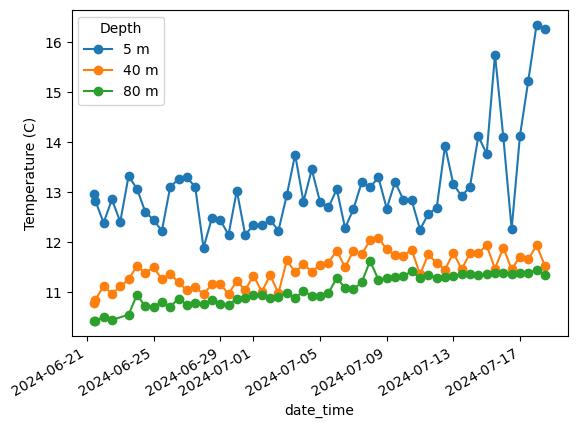

In [27]:
ax = (
    # depth closest to the surface
    buoy_temp_df[buoy_temp_df.depth == 5]
    .plot(x='date_time', y='temp', style='-o', label='5 m')
)
(
    buoy_temp_df[buoy_temp_df.depth == 40]
    .plot(ax=ax, x='date_time', y='temp', style='-o', label='40 m')
)
(
    buoy_temp_df[buoy_temp_df.depth == 80]
    .plot(ax=ax, x='date_time', y='temp', style='-o', label='80 m')
)

plt.legend(title='Depth')
plt.ylabel("Temperature (C)");

## Compare buoy and cruise data

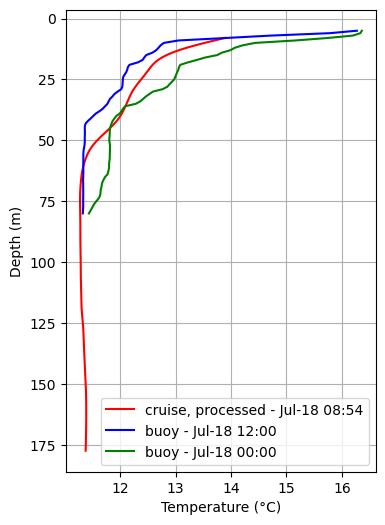

In [28]:
_, ax = plt.subplots(figsize=(4, 6))

# Cruise
# Subtract 7 hours from dcast_time to convert from UTC to local time
proc.plot(ax=ax, y='depth', x='CT', kind='line', color='red', 
          label=f'cruise, processed - {dcast_time - timedelta(hours=7):%h-%d %H:%M}')

# Buoy
(
    # Most recent buoy profile, in the downloaded file
    buoy_temp_df[buoy_temp_df.date_time == buoy_datetimes[-1]]
    .plot(ax=ax, y='depth', x='temp', kind='line', color='blue',
          label=f'buoy - {buoy_datetimes[-1]:%h-%d %H:%M}')
)
(
    # Second most recent buoy profile
    buoy_temp_df[buoy_temp_df.date_time == buoy_datetimes[-2]]
    .plot(ax=ax, y='depth', x='temp', kind='line', color='green',
          label=f'buoy - {buoy_datetimes[-2]:%h-%d %H:%M}')
)

ax.invert_yaxis()
plt.grid(True)
plt.ylabel("Depth (m)")
plt.xlabel("Temperature (°C)");

## Map the locations

The [`folium` package](https://python-visualization.github.io/folium/) provides a convenient tools for creating interactive maps. 

In [29]:
import folium

In [ ]:
# for idx, row in nwis_sites_df.iterrows():
#     folium.Marker(location=[row['latitude'], row['longitude']], 
#                   icon=folium.Icon(color='blue' if row['site_type'] == 'ST' else 'gray'),
#                   popup="<b>{0}</b> {1}. Site type: {2}. {3}".format(
#                       row['code'], row['name'], row['site_type'], row['network'])
#                  ).add_to(m)

In [30]:
m = folium.Map(tiles='ESRI.OceanBasemap')
# m = folium.Map()  # Use default OpenStreetMap tiles

# TODO: Add date & time to the popup text
folium.Marker(
    location=[dcast_lat, dcast_lon],
    icon=folium.Icon(color='red'),
    popup="cruise CTD"
).add_to(m)

folium.Marker(
    location=[buoy_lat, buoy_lon],
    icon=folium.Icon(color='blue'),
    popup="Point Wells ORCA buoy"
).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

m